In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import glob
import sys
import copy
import cv2
from imp import reload
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

<IPython.core.display.Javascript object>

In [28]:
nPosts = 2
spatial_discretisation_step = 0.01
randomisations = 1000

dataDIR = "/mnt/ssd1/Documents/Vivek/locustVR/databases/data_collection/"
projectDB = "/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_20_01_07.db"
expDB = "/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_20_01_07.db"

<IPython.core.display.Javascript object>

In [4]:
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return m

<IPython.core.display.Javascript object>

In [5]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute(
    "Select expId from experiments where project = ? and exp >= ? and exp < ?",
    ("DecisionGeometry", (nPosts - 2) * 10, (nPosts - 1) * 10),
)
fetched = cursorExperiment.fetchall()
print("fetched : " + str(fetched))

fetched : [('c0127c9b-3ff9-4c49-8db4-6900ff4c2b2a',), ('54a35a9f-9eb0-4404-bc9d-8ed7b71192c5',), ('7ac51c48-5f5a-4ac3-9930-56772578c1ee',), ('3a1d5deb-e8f7-48a4-aabb-25456f941c43',), ('752b3218-e802-47e8-bbc6-1049f15e6f85',), ('13e69b2f-9760-4625-a309-511af2c5afb2',), ('2a7c4e5b-deb9-4c55-b0f7-2547034b8b4d',), ('da620536-7437-4bf6-a7de-ba36f19b4177',), ('acb6ec35-e1e0-450a-98ca-581b0f21723e',), ('1730f55c-ba6b-467b-96a8-f23c387f2905',), ('a57b486a-c26a-4016-9722-56846965487e',), ('ded361ec-3214-458a-858f-1be11809fd14',), ('8f13a403-e1bd-4adf-9a4a-ef18b2e4915e',), ('8e0cb790-55be-46b5-be17-f92c2208f12d',), ('5cb7d44f-5166-46ce-b317-f4bd8d3267c5',), ('9e41ebbd-fadd-4ea5-8457-77c541faa137',), ('e62178c9-e0f0-4970-82b6-e26225576f3b',), ('19c69caf-3dc5-4cf4-950c-95acad45ecd9',), ('a678f783-103d-4485-a995-78d7f6b9824e',), ('43f0818a-bae1-44ca-bef9-8823bb8c8ab9',), ('5e103a3b-105b-4820-92e1-b2c2cf2c11ee',), ('2292bbb7-d520-4715-a948-dbd7422e6660',), ('125adcc5-4f9b-47ba-9849-53aa901c5442',), 

<IPython.core.display.Javascript object>

In [6]:
angles = []
dataDict0 = []
dataDict1 = []
rot_post0 = []
for uuid in range(0, len(fetched)):
    cursorExperiment.execute(
        "Select exp from experiments where expId = ?", (fetched[uuid][0],)
    )
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute(
        "Select replicate from experiments where expId = ?", (fetched[uuid][0],)
    )
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute(
        "Select post0 from projects where project = ? and exp = ? and replicate = ?",
        ("DecisionGeometry", fetch_exp, fetch_rep),
    )
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute(
        "Select post1 from projects where project = ? and exp = ? and replicate = ?",
        ("DecisionGeometry", fetch_exp, fetch_rep),
    )
    dataDict1.append(cursorProject.fetchall())

    tmp = pd.read_csv(
        dataDIR + fetched[uuid][0] + "/results.csv",
        names=["x", "y", "z", "event", "t", "nStimuli"],
    )
    tmp["uuid"] = uuid
    tmp["angle"] = np.nan
    tmp["post0_x"] = tmp["post0_y"] = tmp["post1_x"] = tmp["post1_y"] = np.nan
    tmp["nStimuli"] = np.uint8(tmp["nStimuli"])

    tmp3 = pd.DataFrame(
        columns=[
            "index",
            "x",
            "y",
            "z",
            "event",
            "t",
            "nStimuli",
            "uuid",
            "angle",
            "post0_x",
            "post0_y",
            "post1_x",
            "post1_y",
            "selected",
        ]
    )
    for i in np.unique(tmp["nStimuli"]):
        for j in np.unique(tmp.loc[tmp["nStimuli"] == i, "event"]):
            tmp2 = tmp.loc[(tmp["nStimuli"] == i) & (tmp["event"] == j), :]
            tmp2 = tmp2.reset_index()
            tmp2["selected"] = 0

            start_x = tmp2.loc[0, "x"]
            start_y = tmp2.loc[0, "y"]
            for k in range(1, len(tmp2)):
                x = tmp2.loc[k, "x"]
                y = tmp2.loc[k, "y"]
                dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                if dist > spatial_discretisation_step:
                    tmp2.loc[k, "selected"] = 1
                    start_x = x
                    start_y = y
            tmp3 = tmp3.append(tmp2[tmp2["selected"] == 1])

    for a in range(1, 4):
        tmp3.loc[tmp3["nStimuli"] == a, "angle"] = eval(dataDict0[uuid][a][0])["angle"]

    df = tmp3 if uuid == 0 else pd.concat([df, tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])["distance"], 0.0])

    cursorProject.execute(
        "Select post1 from projects where project = ? and exp >= ? and exp < ?",
        ("DecisionGeometry", (nPosts - 2) * 10, (nPosts - 1) * 10),
    )
    for a in np.unique(cursorProject.fetchall()):
        if a != "None" and eval(a)["angle"] not in angles:
            angles.append(eval(a)["angle"])

angles = np.sort(np.array(angles))

<IPython.core.display.Javascript object>

In [7]:
# add post positions to dataframe
nStimuli = np.unique(df["nStimuli"])
for uuid in range(0, len(fetched)):
    for i in range(0, np.nanmax(nStimuli) + 1):
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_x"] = eval(
            dataDict0[uuid][nStimuli[i]][0]
        )["position"][0]
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_y"] = eval(
            dataDict0[uuid][nStimuli[i]][0]
        )["position"][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_x"] = eval(
                dataDict1[uuid][nStimuli[i]][0]
            )["position"][0]
            df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_y"] = eval(
                dataDict1[uuid][nStimuli[i]][0]
            )["position"][1]

# initialise rotation of tracks and posts
df["rotated_x"] = df["rotated_y"] = 0.0
df["rotated_post0_x"] = df["rotated_post0_y"] = df["rotated_post1_x"] = df[
    "rotated_post1_y"
] = 0.0
df["ang"] = 0.0
prerot_idx = 9 + 2 * nPosts
postrot_idx = 9 + 2 * nPosts + 2 + 2 * nPosts

<IPython.core.display.Javascript object>

In [8]:
# get rotation angle
for uuid in range(0, len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.iloc[np.where(df["uuid"] == uuid)[0], postrot_idx + 1] = np.arctan2(
        df.loc[df["uuid"] == uuid, "post0_y"], df.loc[df["uuid"] == uuid, "post0_x"]
    )

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0, len(fetched)):
    if len(np.unique(df.loc[df["uuid"] == uuid, "nStimuli"])) != 0:
        for i in np.unique(df.loc[df["uuid"] == uuid, "nStimuli"]):
            ang = np.unique(
                df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "ang"]
            )[0]
            if i > 0 and i < np.max(nStimuli):
                ang += (nPosts - 1) * eval(dataDict0[uuid][nStimuli[i]][0])["angle"] / 2

            rx, ry = rotate(
                np.array(
                    (
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "x"],
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "y"],
                    )
                ),
                ang,
            )
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_x"
            ] = np.squeeze(np.asarray(rx.T))
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_y"
            ] = np.squeeze(np.asarray(ry.T))

            rp0x, rp0y = rotate(
                np.array(
                    (
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_x"],
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_y"],
                    )
                ),
                ang,
            )
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post0_x"
            ] = np.squeeze(np.asarray(rp0x.T))
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post0_y"
            ] = np.squeeze(np.asarray(rp0y.T))

            rp1x, rp1y = rotate(
                np.array(
                    (
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_x"],
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_y"],
                    )
                ),
                ang,
            )
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post1_x"
            ] = np.squeeze(np.asarray(rp1x.T))
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post1_y"
            ] = np.squeeze(np.asarray(rp1y.T))

<IPython.core.display.Javascript object>

In [9]:
p0_dist = np.sqrt((df["x"] - df["post0_x"]) ** 2 + (df["y"] - df["post0_y"]) ** 2)
p1_dist = np.sqrt((df["x"] - df["post1_x"]) ** 2 + (df["y"] - df["post1_y"]) ** 2)
if nPosts == 2:
    df["dmin"] = np.nanmin([p0_dist, p1_dist], axis=0)
    df["post"] = 0
    df.loc[p1_dist < p0_dist, "post"] = 1
else:
    p2_dist = np.sqrt((df["x"] - df["post2_x"]) ** 2 + (df["y"] - df["post2_y"]) ** 2)
    df["dmin"] = np.nanmin([p0_dist, p1_dist, p2_dist], axis=0)
    df["post"] = 0
    df.loc[(p1_dist < p0_dist) & (p1_dist < p2_dist), "post"] = 1
    df.loc[(p2_dist < p0_dist) & (p2_dist < p1_dist), "post"] = 2

<IPython.core.display.Javascript object>

In [10]:
tmax = df.loc[:, ["uuid", "nStimuli", "event", "t"]]
tmax = tmax.groupby(["uuid", "nStimuli", "event"]).max().reset_index()
dmin = df.loc[:, ["uuid", "nStimuli", "event", "t", "dmin", "post"]]

dists = pd.merge(tmax, dmin, how="left")
dists = dists[dists["dmin"] < 0.5]
dists = dists.loc[:, ["uuid", "nStimuli", "event"]]

df = pd.merge(dists, df, how="left")

<IPython.core.display.Javascript object>

In [11]:
tmp0 = df[df["nStimuli"] == 0]
tmp1 = df[(df["nStimuli"] > 0) & (df["nStimuli"] < 4) & (df["angle"] == angles[0])]
tmp2 = df[(df["nStimuli"] > 0) & (df["nStimuli"] < 4) & (df["angle"] == angles[1])]
tmp3 = df[(df["nStimuli"] > 0) & (df["nStimuli"] < 4) & (df["angle"] == angles[2])]
tmp4 = df[df["nStimuli"] == 4]

<IPython.core.display.Javascript object>

In [12]:
x1s = np.array(tmp2["rotated_x"])
y1s = np.array(tmp2["rotated_y"])

post0_x = np.unique(tmp2["rotated_post0_x"])[0]
post0_y = np.unique(tmp2["rotated_post0_y"])[0]

post1_x = np.unique(tmp2["rotated_post1_x"])[0]
post1_y = np.unique(tmp2["rotated_post1_y"])[0]

<IPython.core.display.Javascript object>

### Extract tracks from second database

In [13]:
projectDB = "/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_19_11_28.db"
expDB = "/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_19_11_28_mod.db"

<IPython.core.display.Javascript object>

In [14]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute(
    "Select expId from experiments where project = ? and exp >= ? and exp < ?",
    ("DecisionGeometry", (nPosts - 2) * 10, (nPosts - 1) * 10),
)
fetched = cursorExperiment.fetchall()
print("fetched : " + str(fetched))

fetched : [('fea86966-c7a8-49f5-bf93-f8a38453e875',), ('32d1f550-279f-4c2a-8456-65483875ad86',), ('a6e70613-9c6b-4417-bc3a-ff0ce95a1ee5',), ('bb9e6a9d-67e1-40de-9f4c-464da0a824ba',), ('353adab2-d51f-4885-adba-508ba2cac467',), ('3a521430-7aa6-412b-8d00-62524874d36a',), ('e3f84ff4-d4b5-415b-9527-5ac834f7cba4',), ('cd75759c-29e2-4ea9-867e-898ee8a02978',), ('fc408072-8c38-4393-83a9-57eade5c057f',), ('b4b1da4d-0aea-4d0c-ba3e-1c113d464135',), ('cc8377c9-e811-40cc-bb67-565e78c0f8bf',), ('e3ce0a89-62ec-47fe-b850-d22b0d0d0527',), ('dd5aac5d-6706-4b09-b50f-bd3cf13cdc91',), ('2f236bc2-25bd-4988-bd6e-f607b9b84f16',), ('19ea8655-cde3-4348-8cb9-8bac6d52668c',), ('209364f5-752f-407b-93c9-b888cd72bed8',), ('d1435f65-5c11-42f9-83db-b222efb9cb46',), ('e60266be-c44d-41a6-a3de-17518bccb1cc',), ('943385e1-c9d0-4f05-bd41-d84bfc3e6760',), ('88f78724-8677-471b-9340-71829d40c2bb',), ('001d9058-7736-4d81-965f-a6daee530e55',), ('06afe132-3a9e-4208-8dcc-b97fb76b927d',), ('1eb32c86-8b1e-4786-a3b4-d87a1299ac21',), 

<IPython.core.display.Javascript object>

In [15]:
angles = []
dataDict0 = []
dataDict1 = []
rot_post0 = []
for uuid in range(0, len(fetched)):
    cursorExperiment.execute(
        "Select exp from experiments where expId = ?", (fetched[uuid][0],)
    )
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute(
        "Select replicate from experiments where expId = ?", (fetched[uuid][0],)
    )
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute(
        "Select post0 from projects where project = ? and exp = ? and replicate = ?",
        ("DecisionGeometry", fetch_exp, fetch_rep),
    )
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute(
        "Select post1 from projects where project = ? and exp = ? and replicate = ?",
        ("DecisionGeometry", fetch_exp, fetch_rep),
    )
    dataDict1.append(cursorProject.fetchall())

    tmp = pd.read_csv(
        dataDIR + fetched[uuid][0] + "/results.csv",
        names=["x", "y", "z", "event", "t", "nStimuli"],
    )
    tmp["uuid"] = uuid
    tmp["angle"] = np.nan
    tmp["post0_x"] = tmp["post0_y"] = tmp["post1_x"] = tmp["post1_y"] = np.nan
    tmp["nStimuli"] = np.uint8(tmp["nStimuli"])

    tmp3 = pd.DataFrame(
        columns=[
            "index",
            "x",
            "y",
            "z",
            "event",
            "t",
            "nStimuli",
            "uuid",
            "angle",
            "post0_x",
            "post0_y",
            "post1_x",
            "post1_y",
            "selected",
        ]
    )
    for i in np.unique(tmp["nStimuli"]):
        for j in np.unique(tmp.loc[tmp["nStimuli"] == i, "event"]):
            tmp2 = tmp.loc[(tmp["nStimuli"] == i) & (tmp["event"] == j), :]
            tmp2 = tmp2.reset_index()
            tmp2["selected"] = 0

            if tmp2.empty != True:
                start_x = tmp2.loc[0, "x"]
                start_y = tmp2.loc[0, "y"]
                for k in range(1, len(tmp2)):
                    x = tmp2.loc[k, "x"]
                    y = tmp2.loc[k, "y"]
                    dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                    if dist > spatial_discretisation_step:
                        tmp2.loc[k, "selected"] = 1
                        start_x = x
                        start_y = y
            tmp3 = tmp3.append(tmp2[tmp2["selected"] == 1])

    for a in range(1, 4):
        tmp3.loc[tmp3["nStimuli"] == a, "angle"] = eval(dataDict0[uuid][a][0])["angle"]

    df = tmp3 if uuid == 0 else pd.concat([df, tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])["distance"], 0.0])

    cursorProject.execute(
        "Select post1 from projects where project = ? and exp >= ? and exp < ?",
        ("DecisionGeometry", (nPosts - 2) * 10, (nPosts - 1) * 10),
    )
    for a in np.unique(cursorProject.fetchall()):
        if a != "None" and eval(a)["angle"] not in angles:
            angles.append(eval(a)["angle"])

angles = np.sort(np.array(angles))

<IPython.core.display.Javascript object>

In [16]:
# add post positions to dataframe
nStimuli = np.unique(df["nStimuli"])
for uuid in range(0, len(fetched)):
    for i in range(0, np.nanmax(nStimuli) + 1):
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_x"] = eval(
            dataDict0[uuid][nStimuli[i]][0]
        )["position"][0]
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_y"] = eval(
            dataDict0[uuid][nStimuli[i]][0]
        )["position"][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_x"] = eval(
                dataDict1[uuid][nStimuli[i]][0]
            )["position"][0]
            df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_y"] = eval(
                dataDict1[uuid][nStimuli[i]][0]
            )["position"][1]

# initialise rotation of tracks and posts
df["rotated_x"] = df["rotated_y"] = 0.0
df["rotated_post0_x"] = df["rotated_post0_y"] = df["rotated_post1_x"] = df[
    "rotated_post1_y"
] = 0.0
df["ang"] = 0.0
prerot_idx = 9 + 2 * nPosts
postrot_idx = 9 + 2 * nPosts + 2 + 2 * nPosts

<IPython.core.display.Javascript object>

In [17]:
# get rotation angle
for uuid in range(0, len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.iloc[np.where(df["uuid"] == uuid)[0], postrot_idx + 1] = np.arctan2(
        df.loc[df["uuid"] == uuid, "post0_y"], df.loc[df["uuid"] == uuid, "post0_x"]
    )

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0, len(fetched)):
    if len(np.unique(df.loc[df["uuid"] == uuid, "nStimuli"])) != 0:
        for i in np.unique(df.loc[df["uuid"] == uuid, "nStimuli"]):
            ang = np.unique(
                df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "ang"]
            )[0]
            if i > 0 and i < np.max(nStimuli):
                ang += (nPosts - 1) * eval(dataDict0[uuid][nStimuli[i]][0])["angle"] / 2

            rx, ry = rotate(
                np.array(
                    (
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "x"],
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "y"],
                    )
                ),
                ang,
            )
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_x"
            ] = np.squeeze(np.asarray(rx.T))
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_y"
            ] = np.squeeze(np.asarray(ry.T))

            rp0x, rp0y = rotate(
                np.array(
                    (
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_x"],
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_y"],
                    )
                ),
                ang,
            )
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post0_x"
            ] = np.squeeze(np.asarray(rp0x.T))
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post0_y"
            ] = np.squeeze(np.asarray(rp0y.T))

            rp1x, rp1y = rotate(
                np.array(
                    (
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_x"],
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_y"],
                    )
                ),
                ang,
            )
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post1_x"
            ] = np.squeeze(np.asarray(rp1x.T))
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post1_y"
            ] = np.squeeze(np.asarray(rp1y.T))

<IPython.core.display.Javascript object>

In [18]:
p0_dist = np.sqrt((df["x"] - df["post0_x"]) ** 2 + (df["y"] - df["post0_y"]) ** 2)
p1_dist = np.sqrt((df["x"] - df["post1_x"]) ** 2 + (df["y"] - df["post1_y"]) ** 2)
if nPosts == 2:
    df["dmin"] = np.nanmin([p0_dist, p1_dist], axis=0)
    df["post"] = 0
    df.loc[p1_dist < p0_dist, "post"] = 1
else:
    p2_dist = np.sqrt((df["x"] - df["post2_x"]) ** 2 + (df["y"] - df["post2_y"]) ** 2)
    df["dmin"] = np.nanmin([p0_dist, p1_dist, p2_dist], axis=0)
    df["post"] = 0
    df.loc[(p1_dist < p0_dist) & (p1_dist < p2_dist), "post"] = 1
    df.loc[(p2_dist < p0_dist) & (p2_dist < p1_dist), "post"] = 2

<IPython.core.display.Javascript object>

In [19]:
tmax = df.loc[:, ["uuid", "nStimuli", "event", "t"]]
tmax = tmax.groupby(["uuid", "nStimuli", "event"]).max().reset_index()
dmin = df.loc[:, ["uuid", "nStimuli", "event", "t", "dmin", "post"]]

dists = pd.merge(tmax, dmin, how="left")
dists = dists[dists["dmin"] < 0.5]
dists = dists.loc[:, ["uuid", "nStimuli", "event"]]

df = pd.merge(dists, df, how="left")

<IPython.core.display.Javascript object>

In [20]:
tmp0 = df[df["nStimuli"] == 0]
tmp1 = df[(df["nStimuli"] > 0) & (df["nStimuli"] < 4) & (df["angle"] == angles[0])]
tmp2 = df[(df["nStimuli"] > 0) & (df["nStimuli"] < 4) & (df["angle"] == angles[1])]
tmp3 = df[(df["nStimuli"] > 0) & (df["nStimuli"] < 4) & (df["angle"] == angles[2])]
tmp4 = df[df["nStimuli"] == 4]

<IPython.core.display.Javascript object>

In [21]:
x2s = np.array(tmp2["rotated_x"])
y2s = np.array(tmp2["rotated_y"])

print(round(post0_x, 3) == round(np.unique(tmp2["rotated_post0_x"])[0], 3))
print(round(post0_y, 3) == round(np.unique(tmp2["rotated_post0_y"])[0], 3))

print(round(post1_x, 3) == round(np.unique(tmp2["rotated_post1_x"])[0], 3))
print(round(post1_y, 3) == round(np.unique(tmp2["rotated_post1_y"])[0], 3))

True
True
True
True


<IPython.core.display.Javascript object>

### Combine tracks and visualise

In [22]:
xs = np.concatenate((x1s, x2s))
ys = np.concatenate((y1s, y2s))

<IPython.core.display.Javascript object>

In [23]:
nbins = 200
peak_threshold = 0.9


def density_map(x, y, stats=True):
    val = 71

    blur = (11, 11) if stats == True else (val, 51)
    r = [[0, post0_x], [post0_y, post1_y]]

    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)
    tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))

    for i in range(0, nbins):
        max_val = np.max(tmp_img[:, i])
        tmp_img[:, i] = tmp_img[:, i] / max_val

    return tmp_img

<IPython.core.display.Javascript object>

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  # This is added back by InteractiveShellApp.init_path()


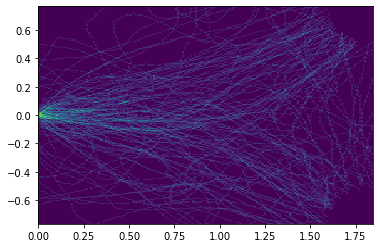

<IPython.core.display.Javascript object>

In [24]:
img = density_map(xs, ys, stats=False)

x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y

([<matplotlib.axis.YTick at 0x7fa8b35a9198>,
 <a list of 3 Text yticklabel objects>)

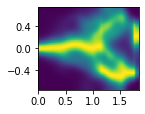

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(post0_x, post1_y * 2))
plt.imshow(img ** 2, extent=[0, post0_x, post0_y, post1_y])
plt.xticks([0, 0.5, 1, 1.5])
plt.yticks([-0.4, 0, 0.4])

### Identify bifurcation point using a piecewise phase-transition function

#### Get first bifurcation point (randomisations)
We cannot produce a reasonable bifurcation post randomisations. Our results are statistically significant and cannot be produced with randomised trajectory points.

In [26]:
def fitfunc(x, p, q, r):
    return r * (np.abs((x - p)) ** q)


def fitfunc_vec_self(x, p, q, r):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q, r)
    return y

<IPython.core.display.Javascript object>

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  # This is added back by InteractiveShellApp.init_path()


100
200
300
400
500
600
700
800
900


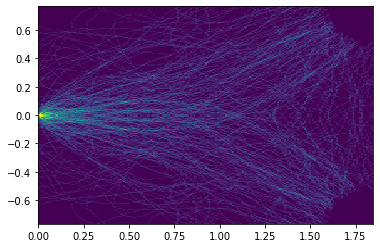

<IPython.core.display.Javascript object>

In [31]:
positive_bif = []

while True:
    bif_pt = 0.8
    params1 = [1, 1, 1]

    x_fit = []
    y_fit = []

    x_sub = np.concatenate((xs, xs))
    y_sub = np.concatenate((ys, -ys))
    np.random.shuffle(y_sub)

    tmp_img = density_map(x_sub, y_sub, stats=True)
    x_fit = np.where(tmp_img > peak_threshold)[1] * post0_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)
    y_fit = y_fit[x_fit > bif_pt]
    x_fit = x_fit[x_fit > bif_pt]

    try:
        for i in range(0, 10):
            fit_params, pcov = curve_fit(
                fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
            )
            params1 = fit_params

        if (
            (params1[0] > 0)
            & (params1[0] < post0_x)
            & (params1[1] > 0.1)
            & (params1[2] > 0.1)
        ):
            positive_bif.append(1)
        else:
            positive_bif.append(0)
    except RuntimeError:
        pass

    if len(positive_bif) >= randomisations:
        break

    if len(positive_bif) % 100 == 0:
        print(len(positive_bif))

In [32]:
np.sum(positive_bif) / len(positive_bif), len(positive_bif)

(1.0, 1000)

<IPython.core.display.Javascript object>